#Paquetes necesarios

# TRAIN YOLO

In [6]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.train(data='platedataset/data.yaml', epochs=3)

Ultralytics YOLOv8.0.203 🚀 Python-3.11.4 torch-2.1.0 CPU (Intel Core(TM) i7-9750H 2.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=platedataset/data.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, opti

In [12]:
class PlateDetector:
    def detect(self, img):
        pass

class PlateMatcher:
    def match(self, text : str) -> bool:
        pass

class TextProcessor:
    def process(self, text : str) -> str:
        pass

class PlateExtractor:
    def __init__(self, matcher : PlateMatcher, processor : TextProcessor):
        self.matcher = matcher
        self.processor = processor

    def extract(self, img):
        pass

In [13]:
class YOLOPlateDetector(PlateDetector):
    def __init__(self, model, category = 0):
        self.model = model
        self.category = category

    def detect(self, img):
        from ultralytics import YOLO
        model = YOLO(self.model)
        results = model(img)
        cars = []
        for x in results:
            boxes = x.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                category = int(box.cls[0])
                if category == 0:
                    cars.append(img[y1:y2, x1:x2])
        return cars

In [14]:
class TesseractPlateExtractor(PlateExtractor):
    def extract(self, img):
        import pytesseract
        pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'
        text = pytesseract.image_to_string(img)
        print(text)
        matcher = RegexPlateMatcher()
        if matcher.match(text):
            text = self.processor.process(text)
            return text
        
class EasyOCRPlateExtractor(PlateExtractor):
    def extract(self, img):
        import easyocr
        reader = easyocr.Reader(['es']) 
        result = reader.readtext(img)
        if(len(result) == 0): return ""
        for x in result:
            text = x[1]
            text = self.processor.process(text)
            if(self.matcher.match(text)):
                return text

class KerasOCRPlateExtractor(PlateExtractor):
    def extract(self, img):
        from keras_ocr.detection import Detector
        from keras_ocr.recognition import Recognizer
        from keras_ocr import pipeline

        detector = Detector()
        recognizer = Recognizer()
        pipeline = pipeline.Pipeline(detector=detector, recognizer=recognizer)
        prediction_groups = pipeline.recognize([img])
        for group in prediction_groups:
            for word in group:
                text = word[0]
                text = self.processor.process(text)
                if(self.matcher.match(text)):
                    return text

In [8]:

class LengthPlateMatcher(PlateMatcher):
    def match(self, text : str) -> bool:
        if len(text) == 7: return True
        return False

class RegexPlateMatcher(PlateMatcher):
    def match(self, text : str) -> bool:
        pattern = re.compile("^[0-9]{4}([B-D]|[F-H]|[J-N]|[P-T]|[V-Z]){3}$")
        if pattern.match(text):
            return True
        else:
            return False

In [9]:
class BasicTextProcessor(TextProcessor):
    def process(self, text : str) -> str:
        text = text.replace(" ", "")
        text = text.replace("-", "")
        return text


0: 384x640 1 License_Plate, 108.0ms
Speed: 2.2ms preprocess, 108.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


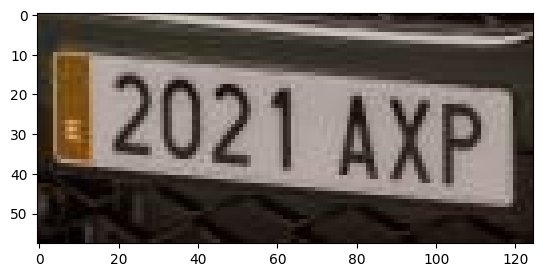

['2O21AXP']


In [17]:
import matplotlib.pyplot as plt
import re
import cv2 as cv

image = cv.imread('./dataset/coches1.jpeg')
processor = BasicTextProcessor()
matcher = LengthPlateMatcher()
detector = YOLOPlateDetector(model='plate_recognizer.pt')
extractor = EasyOCRPlateExtractor(matcher, processor)
cars = detector.detect(image)
detections = [extractor.extract(x) for x in cars]
print(detections)